In [1]:
%%capture
!pip uninstall pytorch-lightning -y
!pip install pytorch-lightning==1.1.8

In [2]:
import os,random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl

In [3]:
!mkdir model-checkpoints

## Change to respective CoLab path here!!

In [4]:
root='/kaggle/input/supervised-dataset/supervised_dataset'
checkpoint_path='/kaggle/working/model-checkpoints'

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, split, transform):
        r"""
        Args:
            root: Location of the dataset folder, usually it is /dataset
            split: The split you want to used, it should be one of train, val or unlabeled.
            transform: the transform you want to applied to the images.
        """

        self.split = split
        self.transform = transform

        self.image_dir = os.path.join(root, split)
        label_path = os.path.join(root, f"{split}_label_tensor.pt")

        self.num_images = len(os.listdir(self.image_dir))

        if os.path.exists(label_path):
            self.labels = torch.load(label_path)
        else:
            self.labels = -1 * torch.ones(self.num_images, dtype=torch.long)
    
    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        with open(os.path.join(self.image_dir, f"{idx}.png"), 'rb') as f:
            img = Image.open(f).convert('RGB')

        return self.transform(img), self.labels[idx]

In [6]:
# Not going to use this,
class FineTunedDataModule(pl.LightningDataModule):

    def __init__(self, root,train_transforms,val_transforms):
        super().__init__()
        self.root = root
        self.train_transforms=train_transforms
        self.val_transforms=val_transforms

    def prepare_data(self):
        # Used to Download
        # We probably do not need this
        pass

    def setup(self, stage):
        # Used to split dataset
        # We probably do not need this
        pass
        
    def train_dataloader(self):
        trainset = CustomDataset(root=root, split="train", transform=train_transform)
        train_loader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)
        return train_loader


    def val_dataloader(self):
        valset = CustomDataset(root=root, split="val", transform=val_transform)
        val_loader = torch.utils.data.DataLoader(evalset, batch_size=256, shuffle=False, num_workers=2)
        return val_loader

#     Not going to define this method purposefully, going to use Jiachen's Evaluation Code so that submission process is also steamlined.    
#     def test_dataloader(self):

In [7]:
class FineTunedModel(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
#         self.model= torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
#         classifier = nn.Linear(2048, 800)
#         classifier.weight.data.normal_(mean=0.0, std=0.01)
#         classifier.bias.data.zero_()
#         self.model.fc=classifier
#         torchvision.models.resnet50(pretrained=False,num_classes=800) #Change here
        self.model=torchvision.models.resnet18(pretrained=False,num_classes=800)
        self.accuracy = pl.metrics.Accuracy()
        self.criterion=torch.nn.CrossEntropyLoss()
    
    def forward(self,x):
        return self.model(x)
    
    def training_step(self,batch,batch_idx):
        x,y=batch
        y_hat=self(x)
        loss=self.criterion(y_hat,y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc',self.accuracy(y_hat,y),on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return {'loss' : loss, 'prediction' : y_hat, 'target' : y}
    
    def validation_step(self,batch,batch_idx):
        x,y=batch
        y_hat=self(x)
        loss=self.criterion(y_hat,y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc',self.accuracy(y_hat,y),on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return {'loss' : loss, 'prediction' : y_hat, 'target' : y}

#     Not going to define this method purposefully, going to use Jiachen's Evaluation Code so that submission process is also steamlined.    
#     def test_step(self,batch,batch_idx):
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

In [8]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [9]:
trainset = CustomDataset(root=root, split="train", transform=train_transforms)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)

valset = CustomDataset(root=root, split="val", transform=val_transforms)
val_loader = torch.utils.data.DataLoader(valset, batch_size=256, shuffle=False, num_workers=2)

In [10]:
# ModelCheckpoint save best model among all epochs, so if we overfit after some number epochs, we still would have the weights of the model before overfitting.
# EarlyStopping(monitor='val_loss') can also be used but it is not thorough
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_path)
trainer = pl.Trainer(gpus=1,deterministic=True,max_epochs=10,callbacks=[checkpoint_callback])

In [11]:
pl.seed_everything(42)

42

In [12]:
model=FineTunedModel()

In [13]:
# We want to find the best learning rate to train the model
lr_finder = trainer.tuner.lr_find(model,train_dataloader=train_loader)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
lr_finder.results

{'lr': [1e-08,
  1.4454397707459274e-08,
  1.7378008287493753e-08,
  2.0892961308540398e-08,
  2.51188643150958e-08,
  3.019951720402016e-08,
  3.630780547701014e-08,
  4.36515832240166e-08,
  5.248074602497726e-08,
  6.309573444801934e-08,
  7.585775750291837e-08,
  9.120108393559096e-08,
  1.0964781961431852e-07,
  1.3182567385564074e-07,
  1.5848931924611133e-07,
  1.9054607179632475e-07,
  2.2908676527677735e-07,
  2.7542287033381663e-07,
  3.311311214825911e-07,
  3.9810717055349735e-07,
  4.786300923226383e-07,
  5.75439937337157e-07,
  6.918309709189366e-07,
  8.317637711026709e-07,
  1e-06,
  1.2022644346174132e-06,
  1.445439770745928e-06,
  1.7378008287493761e-06,
  2.089296130854039e-06,
  2.5118864315095797e-06,
  3.0199517204020163e-06,
  3.630780547701014e-06,
  4.365158322401661e-06,
  5.248074602497728e-06,
  6.3095734448019305e-06,
  7.585775750291836e-06,
  9.120108393559096e-06,
  1.0964781961431852e-05,
  1.3182567385564076e-05,
  1.584893192461114e-05,
  1.90546071

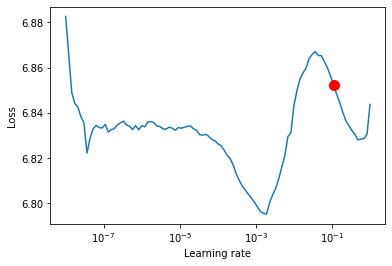

In [15]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [16]:
new_lr = lr_finder.suggestion()
new_lr

0.10964781961431852

In [17]:
val_transforms=train_transforms=transforms.Compose([
    transforms.ToTensor(),
])

In [18]:
trainset = CustomDataset(root=root, split="train", transform=train_transforms)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)

valset = CustomDataset(root=root, split="val", transform=val_transforms)
val_loader = torch.utils.data.DataLoader(valset, batch_size=256, shuffle=False, num_workers=2)

In [19]:
model.hparams.lr = new_lr
trainer.fit(model, train_loader, val_loader)

Validation sanity check: 0it [00:00, ?it/s]

Training: 99it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [20]:
evalset = CustomDataset(root=root, split="val", transform=val_transforms)
evalloader = torch.utils.data.DataLoader(evalset, batch_size=256, shuffle=False, num_workers=2)

net=FineTunedModel()
checkpoint = torch.load(f"/kaggle/working/model-checkpoints/{os.listdir('/kaggle/working/model-checkpoints/')[-1]}",map_location=lambda storage, loc: storage)
net.load_state_dict(checkpoint['state_dict'])
net = net.cuda()

net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in evalloader:
        images, labels = data

        images = images.cuda()
        labels = labels.cuda()

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


print(f"Accuracy: {(100 * correct / total):.2f}%")

Accuracy: 0.12%
